# Load data

In [1]:
import shap  # https://github.com/slundberg/shap

import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dill

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def validate(surrogate, data_loader):
    """
    Calculate mean validation loss.

    Args:
      loss_fn: loss function.
      data_loader: data loader.
    """
    with torch.no_grad():
        # Setup.
        device = next(surrogate.surrogate.parameters()).device
        N = 0
        correct = 0

        for x, y, S in data_loader:
            x = x.to(device)
            y = y.to(device)
            S = S.to(device)
            pred = surrogate(x, S)
            N += len(x)
            correct += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()

    return correct / N

In [3]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Train model

In [4]:
import pickle
import os.path
import lightgbm as lgb

In [5]:
if os.path.isfile("census model.pkl"):
    print("Loading saved model")
    with open("census model.pkl", "rb") as f:
        model = pickle.load(f)

else:
    # Setup
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "min_data": 100,
        "boost_from_average": True,
    }

    # More setup
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_val = lgb.Dataset(X_val, label=Y_val)

    # Train model
    model = lgb.train(
        params,
        d_train,
        10000,
        valid_sets=[d_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(1000)],
    )

    # Save model
    with open("census model.pkl", "wb") as f:
        pickle.dump(model, f)

Loading saved model


In [6]:
# get the predictions of the model on the test set
test_preds = model.predict(X_test)
test_preds = np.round(test_preds)
# compute the accuracy of the model
accuracy = np.mean(test_preds == Y_test)
print(accuracy)

0.876861661292799


# Train surrogate

In [7]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss

In [8]:
# Select device
device = torch.device("cpu")

In [9]:
# Check for model
if os.path.isfile("surrogate_a_muzzo.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("surrogate_a_muzzo.pt").to(device)
    surrogate = Surrogate(surr, num_features)

else:
    # Create surrogate model
    surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * num_features, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 2),
    ).to(device)

    # Set up surrogate object
    surrogate = Surrogate(surr, num_features)

    # Set up original model
    def original_model(x):
        pred = model.predict(x.cpu().numpy())
        pred = np.stack([1 - pred, pred]).T
        return torch.tensor(pred, dtype=torch.float32, device=x.device)

    # Train
    surrogate.train_original_model(
        X_train,
        X_val,
        original_model,
        batch_size=64,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        validation_samples=10,
        validation_batch_size=10000,
        verbose=True,
    )

    # Save surrogate
    surr.cpu()
    torch.save(surr, "surrogate_a_muzzo.pt")
    surr.to(device)

Loading saved surrogate model


In [10]:
# Compute the performances of the surrogates

surrogate_a_muzzo = torch.load("surrogate_a_muzzo.pt").to(device)
surrogate_tuned = torch.load("surrogato_con_hyp_search.pt").to(device)

In [11]:
import random

torch.manual_seed(0)
random.seed(0)

In [12]:
from fastshap.utils import UniformSampler, DatasetRepeat

# get the predictions of the two surrogates on the test set
sampler = UniformSampler(num_features)
S = sampler.sample(X_test.shape[0]).to(device=device)

test_preds_a_muzzo = surrogate_a_muzzo(
    (torch.tensor(X_test, dtype=torch.float32, device=device), S)
)
test_preds_tuned = surrogate_tuned(
    (torch.tensor(X_test, dtype=torch.float32, device=device), S)
)


# argmax of the predictions
test_preds_a_muzzo = test_preds_a_muzzo.argmax(dim=1)
test_preds_tuned = test_preds_tuned.argmax(dim=1)

# compute the accuracy of the two surrogates
accuracy_a_muzzo = np.mean(test_preds_a_muzzo.cpu().numpy() == Y_test)
accuracy_tuned = np.mean(test_preds_tuned.cpu().numpy() == Y_test)
print(f"A muzzo {accuracy_a_muzzo}, Tuned {accuracy_tuned}")

A muzzo 0.8068478427759865, Tuned 0.8099186242898818


In [13]:
# compare two tensors and return the number of different elements
def compare_tensors(a, b):
    return (a == b).sum().item()


print(compare_tensors(test_preds_a_muzzo, torch.tensor(test_preds)))
print(compare_tensors(test_preds_tuned, torch.tensor(test_preds)))

5619
5629


In [14]:
surrogate_tuned = Surrogate(surrogate_tuned, num_features)
surrogate_a_muzzo = Surrogate(surrogate_a_muzzo, num_features)

In [15]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler


def setup_data(train_data, batch_size):
    # Set up train dataset.
    if isinstance(train_data, np.ndarray):
        train_data = torch.tensor(train_data, dtype=torch.float32)

    if isinstance(train_data, torch.Tensor):
        train_set = TensorDataset(train_data)
    elif isinstance(train_data, Dataset):
        train_set = train_data
    else:
        raise ValueError("train_data must be either tensor or a " "PyTorch Dataset")

    # Set up train data loader.
    random_sampler = RandomSampler(
        train_set,
        replacement=True,
        num_samples=int(np.ceil(len(train_set) / batch_size)) * batch_size,
    )
    batch_sampler = BatchSampler(random_sampler, batch_size=batch_size, drop_last=True)
    train_loader = DataLoader(train_set, batch_sampler=batch_sampler)
    return train_loader, random_sampler, batch_sampler


test_loader, _, _ = setup_data(X_test, 32)

# Train FastSHAP

In [16]:
from fastshap import FastSHAP

In [17]:
# Check for model
if os.path.isfile("census explainer.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("census explainer.pt").to(device)
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

else:
    # Create explainer model
    explainer = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * num_features),
    ).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(
        explainer, surrogate_tuned, normalization="additive", link=nn.Softmax(dim=-1)
    )

    # Train
    fastshap.train(
        X_train,
        X_val[:100],
        batch_size=32,
        num_samples=32,
        max_epochs=200,
        validation_samples=128,
        verbose=True,
    )

    # Save explainer
    explainer.cpu()
    torch.save(explainer, "census explainer.pt")
    explainer.to(device)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


----- Epoch = 1 -----
Val loss = 0.069763

New best epoch, loss = 0.069763

----- Epoch = 2 -----
Val loss = 0.062559

New best epoch, loss = 0.062559

----- Epoch = 3 -----
Val loss = 0.060578

New best epoch, loss = 0.060578

----- Epoch = 4 -----
Val loss = 0.057944

New best epoch, loss = 0.057944

----- Epoch = 5 -----
Val loss = 0.057061

New best epoch, loss = 0.057061

----- Epoch = 6 -----
Val loss = 0.056758

New best epoch, loss = 0.056758

----- Epoch = 7 -----
Val loss = 0.055820

New best epoch, loss = 0.055820

----- Epoch = 8 -----
Val loss = 0.055700

New best epoch, loss = 0.055700

----- Epoch = 9 -----
Val loss = 0.055094

New best epoch, loss = 0.055094

----- Epoch = 10 -----
Val loss = 0.054650

New best epoch, loss = 0.054650

----- Epoch = 11 -----
Val loss = 0.054659

----- Epoch = 12 -----
Val loss = 0.054214

New best epoch, loss = 0.054214

----- Epoch = 13 -----
Val loss = 0.054195

New best epoch, loss = 0.054195

----- Epoch = 14 -----
Val loss = 0.05378

In [18]:
dumped_shap_values = dill.load(open("./shap_values.pkl", "rb"))
dumped_results = dill.load(open("./results.pkl", "rb"))
dumped_indexes = dill.load(open("./indexes.pkl", "rb"))

In [19]:
item = dumped_indexes[0]
elements = []
for element in dumped_indexes[1:]:
    if item + 1 != element:
        elements.append(item + 1)
    item = element
print(len(elements))
print(elements)

2
[3951, 4407]


In [20]:
mapping_indexes = {}
for i, index in enumerate(dumped_indexes):
    mapping_indexes[index] = i

In [21]:
mapping_indexes[4450]

4448

# Compare with KernelSHAP

In [22]:
import matplotlib.pyplot as plt

In [23]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate(x, S).softmax(dim=-1)
    return pred.cpu().data.numpy()

In [24]:
# Select example
ind = np.random.choice(len(X_test))
x = X_test[ind : ind + 1]
y = int(Y_test[ind])

# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0]

# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game,
    batch_size=32,
    paired_sampling=False,
    detect_convergence=True,
    bar=True,
    return_all=True,
)

100%|██████████| 1/1 [00:00<00:00,  4.75it/s]     


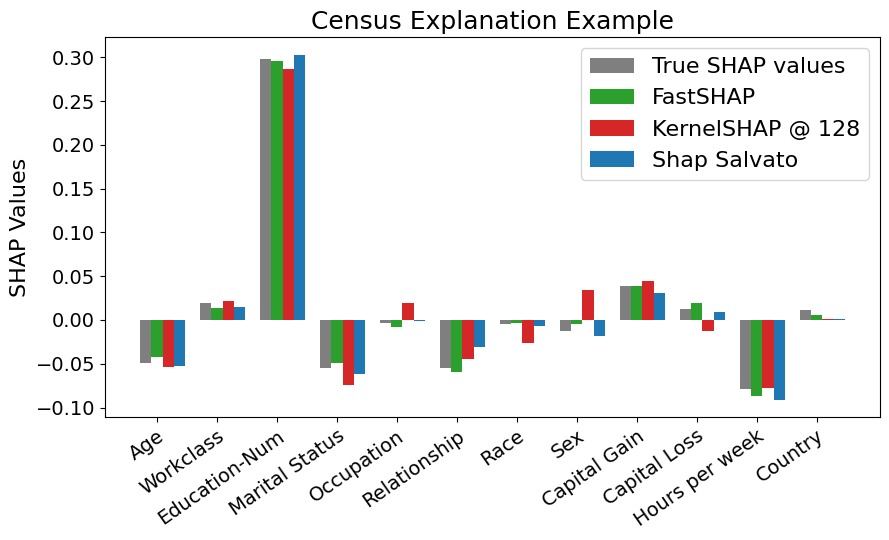

In [25]:
# Create figure
plt.figure(figsize=(9, 5.5))

# Bar chart
width = 0.75
kernelshap_iters = 128
plt.bar(
    np.arange(num_features) - width / 4,
    shap_values.values[:, y],
    width / 4,
    label="True SHAP values",
    color="tab:gray",
)
plt.bar(
    np.arange(num_features),
    fastshap_values[:, y],
    width / 4,
    label="FastSHAP",
    color="tab:green",
)
plt.bar(
    np.arange(num_features) + width / 4,
    all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][:, y],
    width / 4,
    label="KernelSHAP @ {}".format(kernelshap_iters),
    color="tab:red",
)

plt.bar(
    np.arange(num_features) + width / 4 + width / 4,
    dumped_shap_values[dumped_indexes.index(ind)].values[:, y],
    width / 4,
    label="Shap Salvato",
    color="tab:blue",
)

# Annotations
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel("SHAP Values", fontsize=16)
plt.title("Census Explanation Example", fontsize=18)
plt.xticks(
    np.arange(num_features),
    feature_names,
    rotation=35,
    rotation_mode="anchor",
    ha="right",
)

plt.tight_layout()
plt.show()

In [26]:
len(dumped_results)

6511

In [27]:
min(
    [
        max(dumped_results[dumped_indexes.index(ind)]["iters"])
        for index in range(len(dumped_results))
    ]
)

4896

# Comparison Plot 

In [28]:
if os.path.isfile("explainer_nuovo.pt"):
    print("Loading saved expl   ainer model")
    explainer = torch.load("explainer_nuovo.pt").to(device)
    fastshap_tuned = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

In [29]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # set y lim
    # plt.ylim(0, 2)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [30]:
all_indexes = []
for kernelshap_iters in range(32, 1600, 32):
    comp = []
    for ind in dumped_indexes:
        try:
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
            comp.append(ind)
        except:
            continue
    all_indexes.append(comp)

ValueError: x and y must have same first dimension, but have shapes (39,) and (0,)

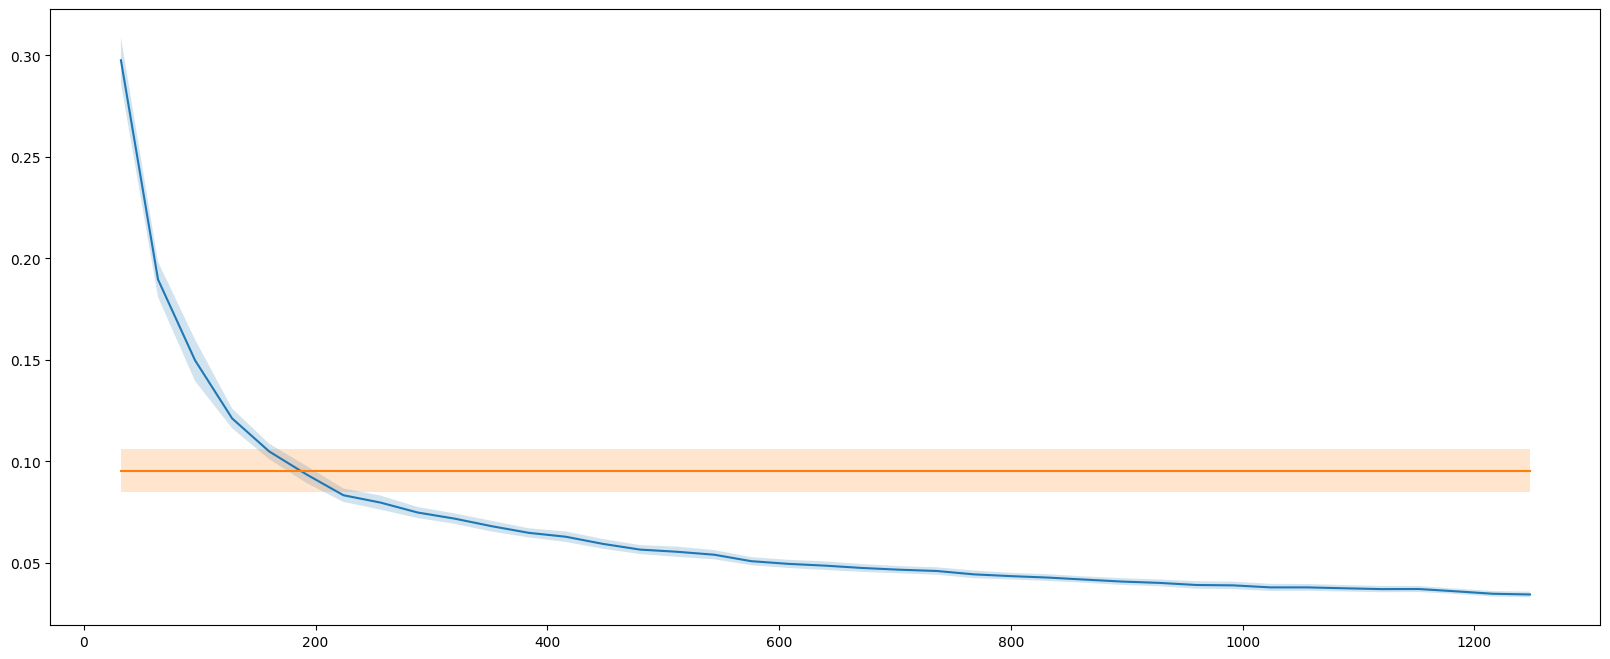

In [34]:
fastshap_values = []
fastshap_tuned_values = []

for ind in dumped_indexes[:50]:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_values.append(fastshap.shap_values(x)[0][:, y])

fastshap_values = np.array(fastshap_values)
fastshap_tuned_values = np.array(fastshap_tuned_values)

results_mean = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_tuned": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_tuned": [],
}

iters = []
for kernelshap_iters in range(32, 1280, 32):
    true_shap_values = []
    kernel_shap_values = []
    correct_indexes = []
    for ind in dumped_indexes[:50]:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        mapped_index = mapping_indexes[ind]
        shap_values = dumped_shap_values[mapped_index]
        all_results = dumped_results[mapped_index]

        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )
        true_shap_values.append(shap_values.values[:, y])
        correct_indexes.append(mapped_index)

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)
    current_fastshap_values = fastshap_values[correct_indexes]

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (current_fastshap_values, "fastshap"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(current_list[0] - true_shap_values, axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

In [ ]:
len(fastshap_values[correct_indexes])

50